### Class Activation Map (Fully Convolutional Net)

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import scipy

/Users/tsuyoshi/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
batch_size = 128
num_classes = 10
epochs = 12
# epochs = 1

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(num_classes, (3, 3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        4672      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 10)        5770      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 10)                0         
__________

In [10]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 133s 2ms/step - loss: 1.5169 - acc: 0.4706 - val_loss: 0.4106 - val_acc: 0.8732
Epoch 2/12
60000/60000 [==============================] - 128s 2ms/step - loss: 0.2780 - acc: 0.9165 - val_loss: 0.1492 - val_acc: 0.9570
Epoch 3/12
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1528 - acc: 0.9539 - val_loss: 0.1480 - val_acc: 0.9547
Epoch 4/12
60000/60000 [==============================] - 139s 2ms/step - loss: 0.1163 - acc: 0.9641 - val_loss: 0.1075 - val_acc: 0.9653
Epoch 5/12
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0951 - acc: 0.9707 - val_loss: 0.0724 - val_acc: 0.9775
Epoch 6/12
60000/60000 [==============================] - 146s 2ms/step - loss: 0.0808 - acc: 0.9750 - val_loss: 0.0804 - val_acc: 0.9745
Epoch 7/12
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0692 - acc: 0.9788 - val_loss: 0.1278 - 

In [12]:
l = model.layers
l

In [13]:
conv_fn = K.function([l[0].input], [l[-3].output]) # Get output of last convolution layer

In [14]:
inp = np.expand_dims(x_test[0], 0) # (28, 28, 1) -> (1, 28, 28, 1)

In [15]:
np.argmax(y_test[0])

7

In [16]:
# Create the class activation map.
def get_cam(inp, target_class_num):
    conv_outputs  = conv_fn([inp])[0] # (1, 14, 14, 10)
    cam = conv_outputs[0, :, :, target_class_num] # (1, 14, 14, 10) -> (14, 14)
    return cam

In [17]:
cam_img = scipy.misc.imresize(get_cam(inp, np.argmax(y_test[0])), (28, 28), interp='nearest')

/Users/tsuyoshi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


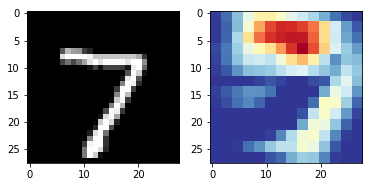

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(inp[0]), cmap='gray')

plt.subplot(1, 2, 2)
# plt.imshow(cam_img, cmap='cool')
plt.imshow(cam_img, cmap='RdYlBu_r')

In [20]:
y_preds = model.predict(x_test)

In [32]:
correct = (np.argmax(y_test, axis=1) == np.argmax(y_preds, axis=1))

/Users/tsuyoshi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


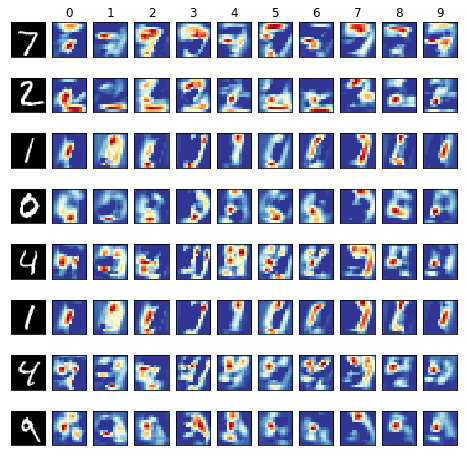

In [33]:
# Input and its activations for each class
plt.figure(figsize=(8,  8))
n_output = 8

for i in range(n_output):
    target_num_indices = np.where(correct)[0]
    x = x_test[target_num_indices, :, :, :][i]
    x = np.expand_dims(x, 0) 
     
    plt.subplot(n_output, num_classes + 1, i * (num_classes + 1) + 1)
    plt.imshow(np.squeeze(x), cmap='gray')
    plt.xticks([])
    plt.yticks([])
        
    for target_class in range(num_classes):    
        cam_img = scipy.misc.imresize(get_cam(x, target_class),  (28, 28), interp='nearest')
    
        plt.subplot(n_output, num_classes + 1, i * (num_classes + 1) + target_class + 2)
        if i == 0:
            plt.title(target_class)
        # plt.imshow(cam_img, cmap='cool')
        plt.imshow(cam_img, cmap='RdYlBu_r')
        plt.xticks([])
        plt.yticks([])